In [1]:
import pandas as pd
import numpy as np
import jieba
import yaml
import matplotlib
import matplotlib.pyplot as plt
import time

from sklearn.cross_validation import train_test_split  
from gensim.models.word2vec import Word2Vec
from gensim.corpora.dictionary import Dictionary
from keras.preprocessing import sequence
from keras.models import model_from_yaml
from keras.optimizers import SGD, RMSprop, Adagrad
# from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM, GRU

from __future__ import absolute_import #导入3.x的特征函数
from __future__ import print_function

C:\Users\lambdal\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\lambdal\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [2]:
# 加载训练文件并分词
#加载训练文件
def loadfile():
    neg=pd.read_excel('./data/neg.xls',header=None,index=None)
    pos=pd.read_excel('./data/pos.xls',header=None,index=None)

    pos['mark']=1
    neg['mark']=0 #给训练语料贴上标签
    pn=pd.concat([pos,neg],ignore_index=True) #合并语料
    neglen=len(neg)
    poslen=len(pos) #计算语料数目
    
    cw = lambda x: list(jieba.cut(x)) #定义分词函数
    pn['words'] = pn[0].apply(cw)
    
    comment = pd.read_excel('./data/sum.xls') #读入评论内容
    comment = comment[comment['rateContent'].notnull()] #仅读取非空评论
    comment['words'] = comment['rateContent'].apply(cw) #评论分词 

    d2v_train = pd.concat([pn['words'], comment['words']], ignore_index = True) 
    
    
    return pn['words'],pn['mark']
#     return d2v_train
    
    

In [3]:
# 创建词语字典，并返回每个词语的索引，词向量，以及每个句子所对应的词语索引
def create_dictionaries(model=None, combined=None):
    ''' Function does are number of Jobs:
        1- Creates a word to index mapping
        2- Creates a word to vector mapping
        3- Transforms the Training and Testing Dictionaries

    '''
    if (combined is not None) and (model is not None):
        gensim_dict = Dictionary()
        gensim_dict.doc2bow(model.wv.vocab.keys(), allow_update=True)
        w2indx = {v: k+1 for k, v in gensim_dict.items()}#所有频数超过10的词语的索引
        w2vec = {word: model[word] for word in w2indx.keys()}#所有频数超过10的词语的词向量

        def parse_dataset(combined):
            ''' Words become integers
            '''
            data=[]
            for sentence in combined:
                new_txt = []
                for word in sentence:
                    try:
                        new_txt.append(w2indx[word])
                    except:
                        new_txt.append(0)
                data.append(new_txt)
            return data
        
        combined = parse_dataset(combined)
        maxlen = 64
        combined = sequence.pad_sequences(combined, maxlen=maxlen)#填充序列，对于长于maxlen的序列进行截断，短语maxlen的序列在后面进行填充0
        return w2indx, w2vec,combined
    else:
        print('No data provided...')


#创建词语字典，并返回每个词语的索引，词向量，以及每个句子所对应的词语索引
def word2vec_train(combined):

    vocab_dim = 300
    n_exposures = 10
    
    model = Word2Vec(sentences=combined, size=vocab_dim, min_count=n_exposures)
#     model.build_vocab(combined)
#     model.train(combined)
    model.save('./lstm_data/Word2vec_model.pkl')
    index_dict, word_vectors,combined = create_dictionaries(model=model,combined=combined)
    return   index_dict, word_vectors,combined

In [4]:
# 训练网络，并保存模型，其中LSTM的实现采用Python中的keras库

def get_data(index_dict,word_vectors,combined,y):
    vocab_dim = 300
    n_symbols = len(index_dict) + 1  # 所有单词的索引数，频数小于10的词语索引为0，所以加1
    embedding_weights = np.zeros((n_symbols, vocab_dim))#索引为0的词语，词向量全为0
    for word, index in index_dict.items():#从索引为1的词语开始，对每个词语对应其词向量
        embedding_weights[index, :] = word_vectors[word]
    x_train, x_test, y_train, y_test = train_test_split(combined, y, test_size=0.2)

    return n_symbols,embedding_weights,x_train,y_train,x_test,y_test


##定义网络结构
def train_lstm(n_symbols,embedding_weights,x_train,y_train,x_test,y_test):
    
    print('Defining a Simple Keras Model...')
    
    model = Sequential()  # or Graph or whatever
    model.add(Embedding(input_dim=n_symbols,
                        output_dim=300,    
                        mask_zero=True,
                        weights=[embedding_weights],
                        input_length=64))  # 当输入序列的长度固定时，该值为其长度,输入序列维度。
    model.add(LSTM(128, input_dim=300, activation='sigmoid', inner_activation='hard_sigmoid'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    print('Compiling the Model...')
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',metrics=['accuracy'])

    print("Train...")
    model.fit(x_train, y_train, batch_size=16, nb_epoch=10,verbose=1, validation_data=(x_test, y_test))

    print("Evaluate...")
    score = model.evaluate(x_test, y_test,
                                batch_size=16)

    yaml_string = model.to_yaml()
    with open('./lstm_data/lstm.yml', 'w') as outfile:
        outfile.write( yaml.dump(yaml_string, default_flow_style=True) )
    model.save_weights('./lstm_data/lstm.h5')
    print('Test score:', score)




In [5]:

#训练模型，并保存
def train():
    print('Loading Data...')
    comment, y =loadfile()
    comment = comment[5000:15000]
    y = y[5000:15000]
    
    print(len(comment),len(y))
    # print('Tokenising...')
    # comment = tokenizer(comment)
    print('Training a Word2vec model...')
    index_dict, word_vectors,comment = word2vec_train(comment)
    
    print('Setting up Arrays for Keras Embedding Layer...')
    n_symbols,embedding_weights,x_train,y_train,x_test,y_test=get_data(index_dict, word_vectors,comment,y)
    print(x_train.shape,y_train.shape)
    
    train_lstm(n_symbols,embedding_weights,x_train,y_train,x_test,y_test)

In [6]:
def predict(model, test):
    label = model.predict(test)
    
    s = []
    for item in label:
        if item>=0.5:
            s.append(1)
        else :
            s.append(0)
    
    import matplotlib
    import matplotlib.pyplot as plt
    plt.hist(s, bins=np.arange(0,1.2,0.25))
    plt.show()

    return label

In [7]:
def main():
    train()
    
    with open('./lstm_data/lstm.yml', 'r') as outfile:
         #导入  
        yaml_string = yaml.load(outfile) 
    

    model = model_from_yaml(yaml_string)
    model.load_weights('./lstm_data/lstm.h5', by_name=False)

    cw = lambda x: list(jieba.cut(x)) #定义分词函数

    comment = pd.read_excel('./data/sum.xls') #读入评论内容
    comment = comment[comment['rateContent'].notnull()] #仅读取非空评论
    comment['words'] = comment['rateContent'].apply(cw) #评论分词 
    data = comment['words']

    index_dict, word_vectors,comment = word2vec_train(data)
    label = predict(model, comment)

Loading Data...


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\lambdal\AppData\Local\Temp\jieba.cache
Loading model cost 1.060 seconds.
Prefix dict has been built succesfully.


10000 10000
Training a Word2vec model...


C:\Users\lambdal\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


Setting up Arrays for Keras Embedding Layer...
(8000, 64) (8000,)
Defining a Simple Keras Model...


C:\Users\lambdal\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
C:\Users\lambdal\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(128, activation="sigmoid", input_shape=(None, 300..., recurrent_activation="hard_sigmoid")`


Compiling the Model...
Train...


C:\Users\lambdal\Anaconda3\lib\site-packages\keras\models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 85s - loss: 0.3320 - acc: 0.8483 - val_loss: 0.1204 - val_acc: 0.9600
Epoch 2/10
8000/8000 [==============================] - 85s - loss: 0.0812 - acc: 0.9726 - val_loss: 0.1020 - val_acc: 0.9600
Epoch 3/10
8000/8000 [==============================] - 85s - loss: 0.0382 - acc: 0.9881 - val_loss: 0.2126 - val_acc: 0.9410
Epoch 4/10
8000/8000 [==============================] - 155s - loss: 0.0274 - acc: 0.9912 - val_loss: 0.0977 - val_acc: 0.9700
Epoch 5/10
8000/8000 [==============================] - 85s - loss: 0.0134 - acc: 0.9959 - val_loss: 0.1213 - val_acc: 0.9700
Epoch 6/10
8000/8000 [==============================] - 165s - loss: 0.0074 - acc: 0.9984 - val_loss: 0.1379 - val_acc: 0.9715
Epoch 7/10
8000/8000 [==============================] - 86s - loss: 0.0089 - acc: 0.9979 - val_loss: 0.1204 - val_acc: 0.9720
Epoch 8/10
8000/8000 [==============================] - 172s - loss:

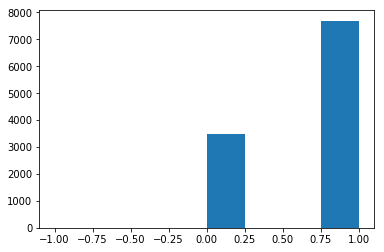

Wall time: 20min 50s


In [8]:
%%time
# 字典长度为3845
if __name__ == "__main__":
    main()
